# Start
This notebook should be as clean and compact as possible (for testing please create/copy a copy of this notebook)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from skimage import color
from skimage.segmentation import slic

from src.util import load_image, downscale
from src.depth import estimate_depth, normalize_depth

In [2]:
# TODO: set the image here (for more complex images set use_kmeans=False)
img_name = "snowmountain.JPG"
use_kmeans = True

In [3]:
orig_img = load_image("dataset/" + img_name)

depth = normalize_depth(estimate_depth(orig_img)) * 100
img = downscale(orig_img, *depth.shape)
img_n, img_m, img_d = img.shape
rgb_slic = slic(img, n_segments=1000, start_label=1, slic_zero=True)

cie_img = color.rgb2lab(img)

xFormers not available
xFormers not available


# Segment-Anything and KMeans

In [4]:
from src.segmentation import SegmentModel, obtain_all_objects, fill_with_superpixels, get_masks, show_layers
from src.kmeans import get_optimal_k, assign2layers_kmeans

/home/koitu/cs413-project/src/InpaintAnything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/koitu/cs413-project/src/InpaintAnything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/koitu/cs413-project/src/InpaintAnything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name b

In [5]:
# lake parameters
mask_generator = SegmentModel(points_per_side=40).segment_anything 
object_masks = obtain_all_objects(mask_generator, img, img_r_thrd=0.95, n_thrd=10, ovlp_r_thrd=0.05, small_thrd=500) 

Iteration n=1: white pixel raito after segmentation = 0.8
Iteration n=2: white pixel raito after segmentation = 0.98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


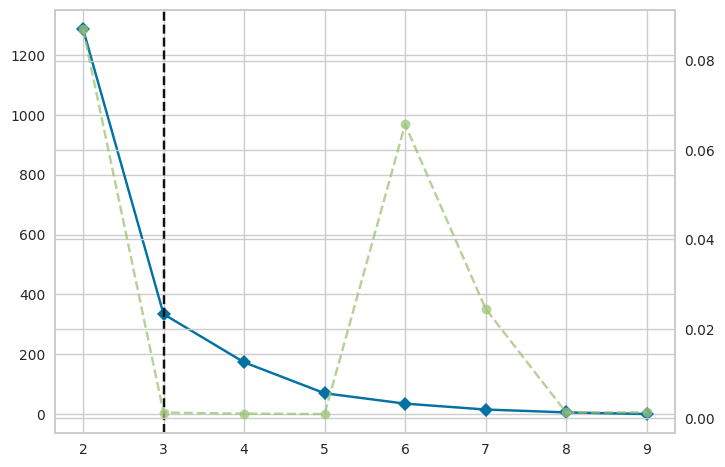

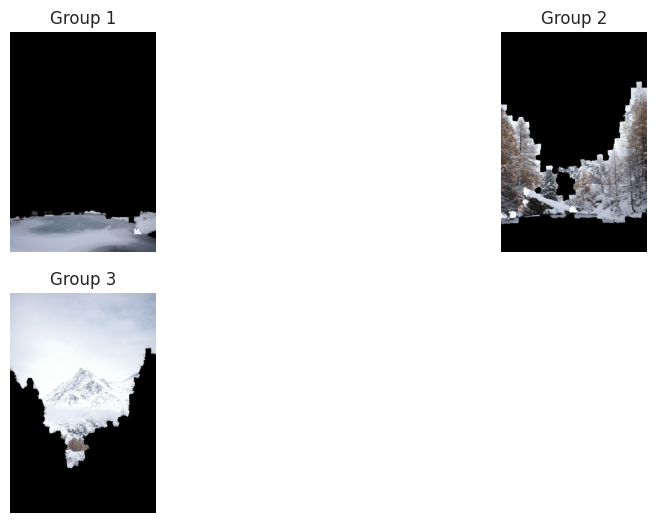

In [6]:
optimal_k = get_optimal_k(object_masks, depth)

object_masks = fill_with_superpixels(img, object_masks)

layers_idx, layers, layer_depth = assign2layers_kmeans(object_masks, depth, optimal_k)

if use_kmeans:
    masks = get_masks(img, object_masks, layers_idx)
    show_layers(img, object_masks, layers_idx)

# Superpixels with Adjacency Graph

In [7]:
from src.graph import RAG

/home/koitu/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [8]:
if not use_kmeans:
    rag = RAG(img, depth, rgb_slic, object_masks)
    masks = rag.get_masks(optimal_k)
    
    plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(321 + i)
    
        image = np.zeros((img_n, img_m, 4))
        image[mask, 3] = 1
        image[mask, 0:3] = img[mask]
        plt.imshow(image)
    plt.show()

# Inpainting

In [9]:
from src.inpaint import InpaintModel

2024-06-02 14:43:24.276920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 14:43:24.303527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 14:43:24.911332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Detectron v2 is not installed


In [10]:
model = InpaintModel(img)
model.set_masks(masks)

if use_kmeans:
    model.auto_generate_layers(link_to_ground=True, filter_layer=True)
else:
    model.auto_generate_layers(link_to_ground=False, filter_layer=True)

images = model.get_outputs()
for i, image in enumerate(images):
    plt.subplot(321 + i)
    plt.imshow(image)
plt.show()

ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8


In [11]:
# save results to output
model.save_outputs('./output/' + img_name.split('.')[0])